# 睿抗 2025 智海人工智能算法应用赛
**语音情绪识别**：音频转梅尔频谱图
- 核心思想：
- 语音序列转为图像，使用图像分类的办法
- 线上测试分数 0.8 左右

In [1]:
import torch
import random
import numpy as np

In [2]:
def set_seed(seed=42):
    random.seed(seed)  # Python 内置随机数
    np.random.seed(seed)  # NumPy 随机数
    torch.manual_seed(seed)  # CPU 上的随机数
    torch.cuda.manual_seed(seed)  # GPU 上的随机数
    torch.cuda.manual_seed_all(seed)  # 多 GPU 情况下的随机数
    torch.backends.cudnn.deterministic = True  # 确保每次卷积结果一致
    torch.backends.cudnn.benchmark = True     

set_seed(42)

In [3]:
import torchaudio.transforms as T
import torchaudio

### 数据观察

In [4]:
import os
import librosa
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

data_path = 'datasets/67fc7ccbb88b01da6626732d-momodel/train/'
emotion_counts = Counter()
durations_per_class = defaultdict(list)
all_durations = []
all_labels = []

# 遍历每个类别文件夹
for emotion in os.listdir(data_path):
    emotion_dir = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    wav_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
    emotion_counts[emotion] += len(wav_files)

    for wav_file in wav_files:
        file_path = os.path.join(emotion_dir, wav_file)
        try:
            y, sr = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations_per_class[emotion].append(duration)
            all_durations.append(duration)
            all_labels.append(emotion)
        except Exception as e:
            print(f"读取失败: {file_path}，原因: {e}")

# === 打印统计信息 ===
print("📊 类别数量统计：")
for emotion, count in emotion_counts.items():
    print(f"  {emotion:>7} : {count} 个样本")

print("\n🎧 音频时长统计：")
print(f"  平均时长: {sum(all_durations)/len(all_durations):.2f} 秒")
print(f"  最短时长: {min(all_durations):.2f} 秒")
print(f"  最长时长: {max(all_durations):.2f} 秒")

# 每类平均时长
print("\n📈 每个类别的平均时长：")
for emotion, durations in durations_per_class.items():
    avg_dur = sum(durations) / len(durations)
    print(f"  {emotion:>7} : {avg_dur:.2f} 秒")

📊 类别数量统计：
    anger : 1642 个样本
     fear : 1350 个样本
    happy : 1622 个样本
  neutral : 1467 个样本
      sad : 1675 个样本

🎧 音频时长统计：
  平均时长: 2.67 秒
  最短时长: 1.25 秒
  最长时长: 7.13 秒

📈 每个类别的平均时长：
    anger : 2.71 秒
     fear : 2.47 秒
    happy : 2.58 秒
  neutral : 2.64 秒
      sad : 2.88 秒


In [5]:
import torchaudio

waveform, sr = torchaudio.load('./datasets/67fc7ccbb88b01da6626732d-momodel/train/neutral/1111.wav')
print("采样率:", sr)

采样率: 44100


### MelSpectrogramDataset
从文件夹结构 Emotion/xxx.wav 读取音频，返回 Log-Mel 频谱图  
输出形状: [1, H=128, W=⩰Time]，后续再做 Resize→224×224


In [6]:
import os, torch, random
import torchaudio.transforms as T
from torch.utils.data import Dataset
from glob import glob

class MelSpectrogramDataset(Dataset):
    """
    从文件夹结构 Emotion/xxx.wav 读取音频，返回 Log-Mel 频谱图
    输出形状: [1, H=128, W=⩰Time]，后续再做 Resize→224×224
    """
    def __init__(self, root_dir, sr=44100, n_mels=128,
                 frame_len=1024, hop_len=512, top_db=80,
                 max_frames=256, augment=False):
        self.paths, self.labels, self.label2idx = [], [], {}
        for idx, emo in enumerate(sorted(os.listdir(root_dir))):
            emo_dir = os.path.join(root_dir, emo)
            if not os.path.isdir(emo_dir): continue
            wavs = glob(os.path.join(emo_dir, "*.wav"))
            self.paths += wavs
            self.labels += [idx]*len(wavs)
            self.label2idx[emo] = idx
            # print(label2idx)

        self.sr = sr
        self.max_frames = max_frames
        self.augment = augment

        self.mel = T.MelSpectrogram(
            sample_rate=sr,
            n_fft=frame_len,
            hop_length=hop_len,
            n_mels=n_mels,
            f_min=32, f_max=sr // 2
        )
        
        self.to_db = T.AmplitudeToDB(top_db=top_db)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
        self.time_mask = T.TimeMasking(time_mask_param=50)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.paths[idx])
        if sr != self.sr:
            wav = T.Resample(sr, self.sr)(wav)

        # 单声道
        if wav.shape[0] > 1: wav = torch.mean(wav, dim=0, keepdim=True)

        spec = self.to_db(self.mel(wav))           
        if self.augment and self.training:          # Dataset 里打个标志即可
            spec = self.freq_mask(spec)
            spec = self.time_mask(spec)

        # 统一时间长度
        if spec.shape[-1] < self.max_frames:
            pad = self.max_frames - spec.shape[-1]
            spec = torch.nn.functional.pad(spec, (0, pad))
        else:
            spec = spec[..., :self.max_frames]

        return spec, torch.tensor(self.labels[idx]).long()

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

root = "datasets/67fc7ccbb88b01da6626732d-momodel/train/"
full_ds = MelSpectrogramDataset(root, augment=True)

indices  = list(range(len(full_ds)))
labels   = full_ds.labels
train_idx, val_idx = train_test_split(indices, test_size=0.2,
                                      stratify=labels, random_state=42)

train_ds = Subset(full_ds, train_idx) ; train_ds.dataset.training = True
val_ds   = Subset(full_ds, val_idx)   ; val_ds.dataset.training   = False

# -------- collate_fn：复制 3 通道 ★ -------- #
def collate_fn(batch):
    specs, labs = zip(*batch)
    specs = torch.stack(specs)                        # [B, 1, 128, 256]
    specs = torch.nn.functional.interpolate(specs, (224, 224),
                                            mode='bilinear', align_corners=False)
    # specs = specs.repeat(1, 3, 1, 1)                  # ★ 复制成 3 通道
    return specs, torch.tensor(labs)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
                          num_workers=4, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4,
                          collate_fn=collate_fn)

In [16]:
label2idx = full_ds.label2idx
label_names = [None] * len(label2idx)
for k, v in label2idx.items():
    label_names[v] = k
print(label_names)


['anger', 'fear', 'happy', 'neutral', 'sad']


In [8]:
# 查看一个 batch 的数据形状
for batch in train_loader:
    features, labels = batch
    print(f"特征 shape: {features.shape}")  # 通常是 [B, T, D]
    print(f"标签 shape: {labels.shape}")    # 通常是 [B]
    break  # 只看第一个 batch 就行

特征 shape: torch.Size([64, 1, 224, 224])
标签 shape: torch.Size([64])



### 随机挑选 N 个样本进行可视化

(224, 224)


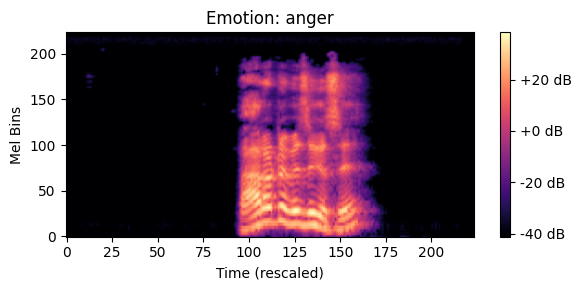

(224, 224)


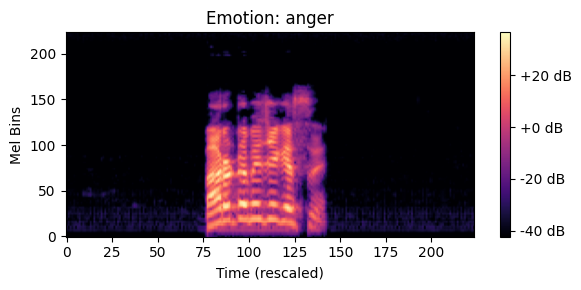

(224, 224)


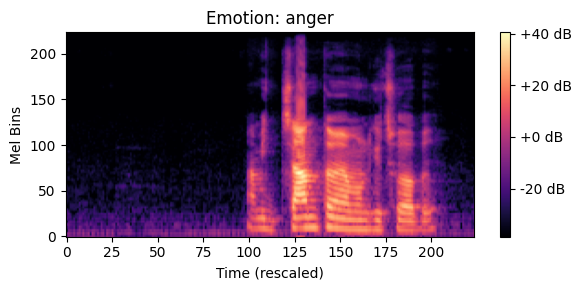

(224, 224)


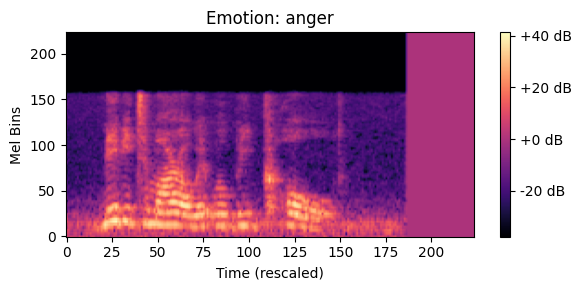

(224, 224)


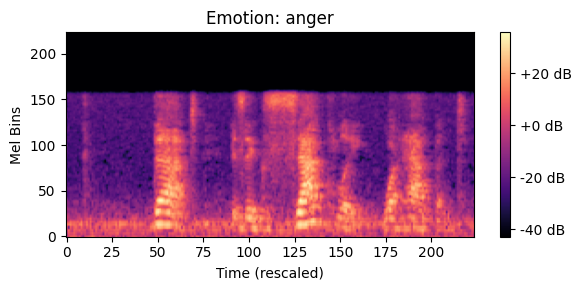

In [9]:
import matplotlib.pyplot as plt
import torchaudio

# 反向映射标签 idx → label 名称
idx2label = {v: k for k, v in full_ds.label2idx.items()}

# 随机挑选 N 个样本进行可视化
N = 5
for i in range(N):
    spec, label = full_ds[i]  # spec: [1, 128, T]
    spec = torch.nn.functional.interpolate(spec.unsqueeze(0), size=(224, 224),
                                           mode='bilinear', align_corners=False)
    spec = spec.squeeze().numpy()  # [224, 224]
    print(spec.shape)
    plt.figure(figsize=(6, 3))
    plt.imshow(spec, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Emotion: {idx2label[label.item()]}")
    plt.xlabel("Time (rescaled)")
    plt.ylabel("Mel Bins")
    plt.tight_layout()
    plt.show()

In [10]:
import torchvision.models as models
import torch, torchvision
import torch.nn as nn
from torchvision.models import *
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


In [11]:
num_classes = len(full_ds.label2idx)
print("num_classes:", num_classes)

# =====================  EfficientNet-B0 模型 ===================== #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_model(num_classes, device):
    # model = models.resnet18(weights="IMAGENET1K_V1")
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 单通道
    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    # model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)  # 保留原始 3 通道权重
    conv1 = model.features[0][0]  # 原始Conv2d(3, 48, ...)
    new_conv = nn.Conv2d(
        in_channels=1,
        out_channels=conv1.out_channels,
        kernel_size=conv1.kernel_size,
        stride=conv1.stride,
        padding=conv1.padding,
        bias=conv1.bias is not None
    )

    # 复制或平均原有权重
    with torch.no_grad():
        new_conv.weight[:] = conv1.weight.mean(dim=1, keepdim=True)

    model.features[0][0] = new_conv  # 替换第一层卷积
    # FC 层改成 num_classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)
    return model

num_classes: 5


## 5. 模型训练

使用`Adam`优化器对网络模型的可训练参数进行优化，并使用`CrossEntropyLoss`交叉熵损失函数计算模型的损失。  

``` python
batch_size = 32  
lr = 0.001   
```

将训练得到的的模型储存到`result/`路径下。  
notebook 环境只能使用 cpu 进行训练，因此将训练代码转为 .py 格式，并在 gpu 环境中训练，具体可参照 `train.py` 文件。





In [13]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 假设 train_ds 是完整训练集（含 label）
full_indices = np.arange(len(full_ds))           # 你的完整 Dataset
full_labels  = np.array(full_ds.labels)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# ==== 配置 ==== #
device = "cuda" if torch.cuda.is_available() else "cpu"
k_folds = 5
max_epochs = 50
patience = 5

# ==== 保存 OOF ==== #
oof_preds = []
oof_labels = []

# ==== K 折交叉验证 ==== #
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
indices = list(range(len(full_ds)))
labels = full_ds.labels

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels), 1):
    print(f"\n===== Fold {fold} =====")

    # 划分子集
    train_ds = Subset(full_ds, train_idx)
    val_ds = Subset(full_ds, val_idx)
    train_ds.dataset.training = True
    val_ds.dataset.training = False

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn)

    # 模型、优化器、损失函数
    model = get_model(num_classes, device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scaler = torch.amp.GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    best_f1 = 0.
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        # —— Train —— #
        model.train()
        tr_pred, tr_lab, tr_loss = [], [], 0.
        for x, y in tqdm(train_loader, desc=f"Fold {fold} | Epoch {epoch}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            tr_loss += loss.item() * x.size(0)
            tr_pred += out.argmax(1).cpu().tolist()
            tr_lab  += y.cpu().tolist()

        tr_f1 = f1_score(tr_lab, tr_pred, average='micro')
        print(f"[Train] Epoch {epoch:02d} | Loss: {tr_loss/len(train_ds):.4f} | F1: {tr_f1:.4f}")

        # —— Eval —— #
        model.eval()
        va_pred, va_lab = [], []
        with torch.no_grad(), torch.amp.autocast(device_type=device):
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                va_pred += out.argmax(1).cpu().tolist()
                va_lab  += y.cpu().tolist()

        va_f1 = f1_score(va_lab, va_pred, average='micro')
        print(f"[Valid] Epoch {epoch:02d} | F1: {va_f1:.4f}")

        # Early Stopping
        if va_f1 > best_f1:
            best_f1 = va_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"model_fold{fold}.pth")
            print(f"  🔥 Saved model_fold{fold}.pth | F1 = {va_f1:.4f}")
        else:
            patience_counter += 1
            print(f"  💤 No improvement. Patience: {patience_counter}/{patience}")

        scheduler.step()

        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping on fold {fold}. Best F1: {best_f1:.4f}")
            break

    # —— 收集 OOF —— #
    oof_preds.extend(va_pred)
    oof_labels.extend(va_lab)

# ==== 计算 OOF 总体 F1 ==== #
oof_f1 = f1_score(oof_labels, oof_preds, average='micro')
print(f"\n🎯 OOF F1 score across all folds: {oof_f1:.4f}")


===== Fold 1 =====


Fold 1 | Epoch 1: 100%|██████████| 96/96 [00:14<00:00,  6.57it/s]

[Train] Epoch 01 | Loss: 1.2334 | F1: 0.4849


[Valid] Epoch 01 | F1: 0.4942
  🔥 Saved model_fold1.pth | F1 = 0.4942


Fold 1 | Epoch 2: 100%|██████████| 96/96 [00:10<00:00,  8.84it/s]


[Train] Epoch 02 | Loss: 0.8006 | F1: 0.6842
[Valid] Epoch 02 | F1: 0.6063
  🔥 Saved model_fold1.pth | F1 = 0.6063


Fold 1 | Epoch 3: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]


[Train] Epoch 03 | Loss: 0.5187 | F1: 0.8096
[Valid] Epoch 03 | F1: 0.6856
  🔥 Saved model_fold1.pth | F1 = 0.6856


Fold 1 | Epoch 4: 100%|██████████| 96/96 [00:10<00:00,  8.85it/s]

[Train] Epoch 04 | Loss: 0.3022 | F1: 0.8971


[Valid] Epoch 04 | F1: 0.6985
  🔥 Saved model_fold1.pth | F1 = 0.6985


Fold 1 | Epoch 5: 100%|██████████| 96/96 [00:10<00:00,  8.84it/s]

[Train] Epoch 05 | Loss: 0.1767 | F1: 0.9419


[Valid] Epoch 05 | F1: 0.7075
  🔥 Saved model_fold1.pth | F1 = 0.7075


Fold 1 | Epoch 6: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]

[Train] Epoch 06 | Loss: 0.1240 | F1: 0.9600


[Valid] Epoch 06 | F1: 0.7107
  🔥 Saved model_fold1.pth | F1 = 0.7107


Fold 1 | Epoch 7: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]

[Train] Epoch 07 | Loss: 0.0806 | F1: 0.9746


[Valid] Epoch 07 | F1: 0.7223
  🔥 Saved model_fold1.pth | F1 = 0.7223


Fold 1 | Epoch 8: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]


[Train] Epoch 08 | Loss: 0.0618 | F1: 0.9814
[Valid] Epoch 08 | F1: 0.7184
  💤 No improvement. Patience: 1/5


Fold 1 | Epoch 9: 100%|██████████| 96/96 [00:10<00:00,  8.84it/s]

[Train] Epoch 09 | Loss: 0.0549 | F1: 0.9832


[Valid] Epoch 09 | F1: 0.7133
  💤 No improvement. Patience: 2/5


Fold 1 | Epoch 10: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]

[Train] Epoch 10 | Loss: 0.0518 | F1: 0.9842


[Valid] Epoch 10 | F1: 0.7204
  💤 No improvement. Patience: 3/5


Fold 1 | Epoch 11: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]


[Train] Epoch 11 | Loss: 0.0479 | F1: 0.9845
[Valid] Epoch 11 | F1: 0.7184
  💤 No improvement. Patience: 4/5


Fold 1 | Epoch 12: 100%|██████████| 96/96 [00:11<00:00,  8.61it/s]

[Train] Epoch 12 | Loss: 0.0380 | F1: 0.9875


[Valid] Epoch 12 | F1: 0.7300
  🔥 Saved model_fold1.pth | F1 = 0.7300


Fold 1 | Epoch 13: 100%|██████████| 96/96 [00:10<00:00,  8.85it/s]


[Train] Epoch 13 | Loss: 0.0378 | F1: 0.9878
[Valid] Epoch 13 | F1: 0.7287
  💤 No improvement. Patience: 1/5


Fold 1 | Epoch 14: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 14 | Loss: 0.0289 | F1: 0.9904


[Valid] Epoch 14 | F1: 0.7487
  🔥 Saved model_fold1.pth | F1 = 0.7487


Fold 1 | Epoch 15: 100%|██████████| 96/96 [00:10<00:00,  8.84it/s]


[Train] Epoch 15 | Loss: 0.0333 | F1: 0.9889
[Valid] Epoch 15 | F1: 0.7262
  💤 No improvement. Patience: 1/5


Fold 1 | Epoch 16: 100%|██████████| 96/96 [00:10<00:00,  8.87it/s]


[Train] Epoch 16 | Loss: 0.0273 | F1: 0.9897
[Valid] Epoch 16 | F1: 0.7294
  💤 No improvement. Patience: 2/5


Fold 1 | Epoch 17: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]


[Train] Epoch 17 | Loss: 0.0289 | F1: 0.9906
[Valid] Epoch 17 | F1: 0.7429
  💤 No improvement. Patience: 3/5


Fold 1 | Epoch 18: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]

[Train] Epoch 18 | Loss: 0.0202 | F1: 0.9951


[Valid] Epoch 18 | F1: 0.7403
  💤 No improvement. Patience: 4/5


Fold 1 | Epoch 19: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]


[Train] Epoch 19 | Loss: 0.0219 | F1: 0.9927
[Valid] Epoch 19 | F1: 0.7416
  💤 No improvement. Patience: 5/5

⏹️ Early stopping on fold 1. Best F1: 0.7487

===== Fold 2 =====


Fold 2 | Epoch 1: 100%|██████████| 96/96 [00:10<00:00,  8.86it/s]


[Train] Epoch 01 | Loss: 1.2390 | F1: 0.4818
[Valid] Epoch 01 | F1: 0.5016
  🔥 Saved model_fold2.pth | F1 = 0.5016


Fold 2 | Epoch 2: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]

[Train] Epoch 02 | Loss: 0.7878 | F1: 0.6864


[Valid] Epoch 02 | F1: 0.6157
  🔥 Saved model_fold2.pth | F1 = 0.6157


Fold 2 | Epoch 3: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]


[Train] Epoch 03 | Loss: 0.5076 | F1: 0.8092
[Valid] Epoch 03 | F1: 0.6918
  🔥 Saved model_fold2.pth | F1 = 0.6918


Fold 2 | Epoch 4: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]

[Train] Epoch 04 | Loss: 0.2958 | F1: 0.8962


[Valid] Epoch 04 | F1: 0.6815
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 5: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]


[Train] Epoch 05 | Loss: 0.1847 | F1: 0.9375
[Valid] Epoch 05 | F1: 0.6925
  🔥 Saved model_fold2.pth | F1 = 0.6925


Fold 2 | Epoch 6: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 06 | Loss: 0.1052 | F1: 0.9678


[Valid] Epoch 06 | F1: 0.7079
  🔥 Saved model_fold2.pth | F1 = 0.7079


Fold 2 | Epoch 7: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]


[Train] Epoch 07 | Loss: 0.0891 | F1: 0.9727
[Valid] Epoch 07 | F1: 0.6796
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 8: 100%|██████████| 96/96 [00:10<00:00,  8.77it/s]

[Train] Epoch 08 | Loss: 0.0791 | F1: 0.9757


[Valid] Epoch 08 | F1: 0.6899
  💤 No improvement. Patience: 2/5


Fold 2 | Epoch 9: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]

[Train] Epoch 09 | Loss: 0.0643 | F1: 0.9787


[Valid] Epoch 09 | F1: 0.7131
  🔥 Saved model_fold2.pth | F1 = 0.7131


Fold 2 | Epoch 10: 100%|██████████| 96/96 [00:10<00:00,  8.76it/s]


[Train] Epoch 10 | Loss: 0.0475 | F1: 0.9863
[Valid] Epoch 10 | F1: 0.7021
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 11: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]

[Train] Epoch 11 | Loss: 0.0606 | F1: 0.9810


[Valid] Epoch 11 | F1: 0.6989
  💤 No improvement. Patience: 2/5


Fold 2 | Epoch 12: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]


[Train] Epoch 12 | Loss: 0.0373 | F1: 0.9876
[Valid] Epoch 12 | F1: 0.7105
  💤 No improvement. Patience: 3/5


Fold 2 | Epoch 13: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]

[Train] Epoch 13 | Loss: 0.0404 | F1: 0.9873


[Valid] Epoch 13 | F1: 0.7208
  🔥 Saved model_fold2.pth | F1 = 0.7208


Fold 2 | Epoch 14: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]


[Train] Epoch 14 | Loss: 0.0296 | F1: 0.9904
[Valid] Epoch 14 | F1: 0.7195
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 15: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]

[Train] Epoch 15 | Loss: 0.0256 | F1: 0.9925


[Valid] Epoch 15 | F1: 0.7118
  💤 No improvement. Patience: 2/5


Fold 2 | Epoch 16: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]


[Train] Epoch 16 | Loss: 0.0265 | F1: 0.9919
[Valid] Epoch 16 | F1: 0.7331
  🔥 Saved model_fold2.pth | F1 = 0.7331


Fold 2 | Epoch 17: 100%|██████████| 96/96 [00:10<00:00,  8.76it/s]


[Train] Epoch 17 | Loss: 0.0223 | F1: 0.9919
[Valid] Epoch 17 | F1: 0.7176
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 18: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 18 | Loss: 0.0250 | F1: 0.9920


[Valid] Epoch 18 | F1: 0.7337
  🔥 Saved model_fold2.pth | F1 = 0.7337


Fold 2 | Epoch 19: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]


[Train] Epoch 19 | Loss: 0.0139 | F1: 0.9958
[Valid] Epoch 19 | F1: 0.7150
  💤 No improvement. Patience: 1/5


Fold 2 | Epoch 20: 100%|██████████| 96/96 [00:11<00:00,  8.57it/s]

[Train] Epoch 20 | Loss: 0.0184 | F1: 0.9943


[Valid] Epoch 20 | F1: 0.7170
  💤 No improvement. Patience: 2/5


Fold 2 | Epoch 21: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 21 | Loss: 0.0160 | F1: 0.9961


[Valid] Epoch 21 | F1: 0.7324
  💤 No improvement. Patience: 3/5


Fold 2 | Epoch 22: 100%|██████████| 96/96 [00:10<00:00,  8.76it/s]

[Train] Epoch 22 | Loss: 0.0171 | F1: 0.9948


[Valid] Epoch 22 | F1: 0.7279
  💤 No improvement. Patience: 4/5


Fold 2 | Epoch 23: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]


[Train] Epoch 23 | Loss: 0.0115 | F1: 0.9963
[Valid] Epoch 23 | F1: 0.7324
  💤 No improvement. Patience: 5/5

⏹️ Early stopping on fold 2. Best F1: 0.7337

===== Fold 3 =====


Fold 3 | Epoch 1: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 01 | Loss: 1.2449 | F1: 0.4871


[Valid] Epoch 01 | F1: 0.5358
  🔥 Saved model_fold3.pth | F1 = 0.5358


Fold 3 | Epoch 2: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]


[Train] Epoch 02 | Loss: 0.8185 | F1: 0.6777
[Valid] Epoch 02 | F1: 0.5938
  🔥 Saved model_fold3.pth | F1 = 0.5938


Fold 3 | Epoch 3: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]

[Train] Epoch 03 | Loss: 0.5464 | F1: 0.7959


[Valid] Epoch 03 | F1: 0.7047
  🔥 Saved model_fold3.pth | F1 = 0.7047


Fold 3 | Epoch 4: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 04 | Loss: 0.3281 | F1: 0.8828


[Valid] Epoch 04 | F1: 0.7015
  💤 No improvement. Patience: 1/5


Fold 3 | Epoch 5: 100%|██████████| 96/96 [00:10<00:00,  8.75it/s]

[Train] Epoch 05 | Loss: 0.1963 | F1: 0.9325


[Valid] Epoch 05 | F1: 0.7105
  🔥 Saved model_fold3.pth | F1 = 0.7105


Fold 3 | Epoch 6: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]

[Train] Epoch 06 | Loss: 0.1313 | F1: 0.9575


[Valid] Epoch 06 | F1: 0.7170
  🔥 Saved model_fold3.pth | F1 = 0.7170


Fold 3 | Epoch 7: 100%|██████████| 96/96 [00:11<00:00,  8.71it/s]


[Train] Epoch 07 | Loss: 0.1024 | F1: 0.9665
[Valid] Epoch 07 | F1: 0.7421
  🔥 Saved model_fold3.pth | F1 = 0.7421


Fold 3 | Epoch 8: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 08 | Loss: 0.0844 | F1: 0.9709


[Valid] Epoch 08 | F1: 0.7260
  💤 No improvement. Patience: 1/5


Fold 3 | Epoch 9: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]

[Train] Epoch 09 | Loss: 0.0581 | F1: 0.9811


[Valid] Epoch 09 | F1: 0.7318
  💤 No improvement. Patience: 2/5


Fold 3 | Epoch 10: 100%|██████████| 96/96 [00:11<00:00,  8.58it/s]

[Train] Epoch 10 | Loss: 0.0542 | F1: 0.9827


[Valid] Epoch 10 | F1: 0.7311
  💤 No improvement. Patience: 3/5


Fold 3 | Epoch 11: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 11 | Loss: 0.0423 | F1: 0.9875


[Valid] Epoch 11 | F1: 0.7299
  💤 No improvement. Patience: 4/5


Fold 3 | Epoch 12: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 12 | Loss: 0.0433 | F1: 0.9871


[Valid] Epoch 12 | F1: 0.7311
  💤 No improvement. Patience: 5/5

⏹️ Early stopping on fold 3. Best F1: 0.7421

===== Fold 4 =====


Fold 4 | Epoch 1: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]

[Train] Epoch 01 | Loss: 1.2213 | F1: 0.4925


[Valid] Epoch 01 | F1: 0.5093
  🔥 Saved model_fold4.pth | F1 = 0.5093


Fold 4 | Epoch 2: 100%|██████████| 96/96 [00:11<00:00,  8.71it/s]

[Train] Epoch 02 | Loss: 0.7861 | F1: 0.6908


[Valid] Epoch 02 | F1: 0.6061
  🔥 Saved model_fold4.pth | F1 = 0.6061


Fold 4 | Epoch 3: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]


[Train] Epoch 03 | Loss: 0.5106 | F1: 0.8141
[Valid] Epoch 03 | F1: 0.6892
  🔥 Saved model_fold4.pth | F1 = 0.6892


Fold 4 | Epoch 4: 100%|██████████| 96/96 [00:11<00:00,  8.72it/s]

[Train] Epoch 04 | Loss: 0.2919 | F1: 0.8981


[Valid] Epoch 04 | F1: 0.7002
  🔥 Saved model_fold4.pth | F1 = 0.7002


Fold 4 | Epoch 5: 100%|██████████| 96/96 [00:10<00:00,  8.75it/s]

[Train] Epoch 05 | Loss: 0.1785 | F1: 0.9395


[Valid] Epoch 05 | F1: 0.7228
  🔥 Saved model_fold4.pth | F1 = 0.7228


Fold 4 | Epoch 6: 100%|██████████| 96/96 [00:10<00:00,  8.81it/s]

[Train] Epoch 06 | Loss: 0.1127 | F1: 0.9650


[Valid] Epoch 06 | F1: 0.7195
  💤 No improvement. Patience: 1/5


Fold 4 | Epoch 7: 100%|██████████| 96/96 [00:10<00:00,  8.77it/s]

[Train] Epoch 07 | Loss: 0.0831 | F1: 0.9718


[Valid] Epoch 07 | F1: 0.7195
  💤 No improvement. Patience: 2/5


Fold 4 | Epoch 8: 100%|██████████| 96/96 [00:10<00:00,  8.77it/s]


[Train] Epoch 08 | Loss: 0.0726 | F1: 0.9780
[Valid] Epoch 08 | F1: 0.7228
  💤 No improvement. Patience: 3/5


Fold 4 | Epoch 9: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]


[Train] Epoch 09 | Loss: 0.0550 | F1: 0.9831
[Valid] Epoch 09 | F1: 0.7253
  🔥 Saved model_fold4.pth | F1 = 0.7253


Fold 4 | Epoch 10: 100%|██████████| 96/96 [00:11<00:00,  8.46it/s]

[Train] Epoch 10 | Loss: 0.0540 | F1: 0.9824


[Valid] Epoch 10 | F1: 0.7034
  💤 No improvement. Patience: 1/5


Fold 4 | Epoch 11: 100%|██████████| 96/96 [00:10<00:00,  8.77it/s]


[Train] Epoch 11 | Loss: 0.0519 | F1: 0.9849
[Valid] Epoch 11 | F1: 0.7447
  🔥 Saved model_fold4.pth | F1 = 0.7447


Fold 4 | Epoch 12: 100%|██████████| 96/96 [00:10<00:00,  8.80it/s]


[Train] Epoch 12 | Loss: 0.0354 | F1: 0.9880
[Valid] Epoch 12 | F1: 0.7363
  💤 No improvement. Patience: 1/5


Fold 4 | Epoch 13: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]

[Train] Epoch 13 | Loss: 0.0337 | F1: 0.9881


[Valid] Epoch 13 | F1: 0.7363
  💤 No improvement. Patience: 2/5


Fold 4 | Epoch 14: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]


[Train] Epoch 14 | Loss: 0.0270 | F1: 0.9924
[Valid] Epoch 14 | F1: 0.7350
  💤 No improvement. Patience: 3/5


Fold 4 | Epoch 15: 100%|██████████| 96/96 [00:10<00:00,  8.83it/s]


[Train] Epoch 15 | Loss: 0.0300 | F1: 0.9897
[Valid] Epoch 15 | F1: 0.7311
  💤 No improvement. Patience: 4/5


Fold 4 | Epoch 16: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 16 | Loss: 0.0242 | F1: 0.9919


[Valid] Epoch 16 | F1: 0.7292
  💤 No improvement. Patience: 5/5

⏹️ Early stopping on fold 4. Best F1: 0.7447

===== Fold 5 =====


Fold 5 | Epoch 1: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]

[Train] Epoch 01 | Loss: 1.2352 | F1: 0.4917


[Valid] Epoch 01 | F1: 0.5435
  🔥 Saved model_fold5.pth | F1 = 0.5435


Fold 5 | Epoch 2: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]


[Train] Epoch 02 | Loss: 0.8005 | F1: 0.6813
[Valid] Epoch 02 | F1: 0.6596
  🔥 Saved model_fold5.pth | F1 = 0.6596


Fold 5 | Epoch 3: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 03 | Loss: 0.5125 | F1: 0.8133


[Valid] Epoch 03 | F1: 0.6976
  🔥 Saved model_fold5.pth | F1 = 0.6976


Fold 5 | Epoch 4: 100%|██████████| 96/96 [00:10<00:00,  8.79it/s]

[Train] Epoch 04 | Loss: 0.2944 | F1: 0.9023


[Valid] Epoch 04 | F1: 0.6989
  🔥 Saved model_fold5.pth | F1 = 0.6989


Fold 5 | Epoch 5: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]

[Train] Epoch 05 | Loss: 0.1866 | F1: 0.9421


[Valid] Epoch 05 | F1: 0.6879
  💤 No improvement. Patience: 1/5


Fold 5 | Epoch 6: 100%|██████████| 96/96 [00:10<00:00,  8.82it/s]


[Train] Epoch 06 | Loss: 0.1056 | F1: 0.9684
[Valid] Epoch 06 | F1: 0.7318
  🔥 Saved model_fold5.pth | F1 = 0.7318


Fold 5 | Epoch 7: 100%|██████████| 96/96 [00:11<00:00,  8.61it/s]

[Train] Epoch 07 | Loss: 0.0870 | F1: 0.9718


[Valid] Epoch 07 | F1: 0.7279
  💤 No improvement. Patience: 1/5


Fold 5 | Epoch 8: 100%|██████████| 96/96 [00:11<00:00,  8.71it/s]

[Train] Epoch 08 | Loss: 0.0657 | F1: 0.9798


[Valid] Epoch 08 | F1: 0.7305
  💤 No improvement. Patience: 2/5


Fold 5 | Epoch 9: 100%|██████████| 96/96 [00:10<00:00,  8.74it/s]

[Train] Epoch 09 | Loss: 0.0600 | F1: 0.9814


[Valid] Epoch 09 | F1: 0.7079
  💤 No improvement. Patience: 3/5


Fold 5 | Epoch 10: 100%|██████████| 96/96 [00:10<00:00,  8.78it/s]


[Train] Epoch 10 | Loss: 0.0416 | F1: 0.9876
[Valid] Epoch 10 | F1: 0.7299
  💤 No improvement. Patience: 4/5


Fold 5 | Epoch 11: 100%|██████████| 96/96 [00:10<00:00,  8.75it/s]

[Train] Epoch 11 | Loss: 0.0444 | F1: 0.9881


[Valid] Epoch 11 | F1: 0.7305
  💤 No improvement. Patience: 5/5

⏹️ Early stopping on fold 5. Best F1: 0.7318

🎯 OOF F1 score across all folds: 0.7330


## 6. 模型评估

对训练好的模型，可以测试其在数据集上的评分。  
本样例代码没有将数据集划分为训练集与验证集，因此测试所得分数不能准确体现模型的性能。  
同学们可以将数据集进行划分以实现更准确的性能评估。  


In [ ]:
import torch
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes, device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算评估指标
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='micro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

## 模型推理

In [37]:
print(full_ds.label2idx)

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}


In [68]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as audiof
import numpy as np
import glob
from torchvision.models import *
import torch.nn as nn
import torch.nn.functional as F

# =====================  EfficientNet-B5 模型 ===================== #
def get_model(num_classes, device):
    # model = models.resnet18(weights="IMAGENET1K_V1")
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 单通道
    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    # model = model.to("cuda" if torch.cuda.is_available() else "cpu")
#     model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)  # 保留原始 3 通道权重
    model = efficientnet_b5()
    conv1 = model.features[0][0]  # 原始Conv2d(3, 48, ...)
    new_conv = nn.Conv2d(
        in_channels=1,
        out_channels=conv1.out_channels,
        kernel_size=conv1.kernel_size,
        stride=conv1.stride,
        padding=conv1.padding,
        bias=conv1.bias is not None
    )

    # 复制或平均原有权重
    with torch.no_grad():
        new_conv.weight[:] = conv1.weight.mean(dim=1, keepdim=True)

    model.features[0][0] = new_conv  # 替换第一层卷积
    # FC 层改成 num_classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)
    
    return model

# ========= 载入五折模型 =========
def load_five_fold_models():
    paths = sorted(glob.glob("results/model_fold*.pth"))
    assert len(paths) == 5, f"需要 5 个折权重，找到 {len(paths)} 个"
    nets = []
    for p in paths:
        net = get_model(num_classes=num_classes, device=device)
        net.load_state_dict(torch.load(p, map_location=device))
        net.eval()
        nets.append(net)
    print("✅ 已加载 5 折模型")
    return nets


# ========= 标签 =========
label_names = ['anger', 'fear', 'happy', 'neutral', 'sad']
print("num_classes:", len(label_names))

device = torch.device("cpu")
models = load_five_fold_models()

class InferenceDataset(Dataset):
    def __init__(self, audio, sr_orig,
                 sr_target=44100, n_mels=128,
                 frame_len=1024, hop_len=512,
                 top_db=80, max_frames=256):
        self.wav = audio
        self.sr_orig = sr_orig
        self.sr_target = sr_target
        self.max_frames = max_frames

        self.mel = T.MelSpectrogram(
            sample_rate=sr_target,
            n_fft=frame_len,
            hop_length=hop_len,
            n_mels=n_mels,
            f_min=32, f_max=sr_target // 2
        )
        self.to_db = T.AmplitudeToDB(top_db=top_db)

    def __len__(self): return 1

    def __getitem__(self, idx):
        wav = self.wav
        if self.sr_orig != self.sr_target:
            wav = T.Resample(self.sr_orig, self.sr_target)(wav)
        if wav.shape[0] > 1:
            wav = wav.mean(0, keepdim=True)

        spec = self.to_db(self.mel(wav))  # [1,128,T]
        if spec.shape[-1] < self.max_frames:
            spec = F.pad(spec, (0, self.max_frames - spec.shape[-1]))
        else:
            spec = spec[..., :self.max_frames]
        return spec  # 只返回 spec

def collate_fn(batch):
    specs = torch.stack(batch)                       # [B,1,128,256]
    specs = F.interpolate(specs, (224,224), mode='bilinear', align_corners=False)
    return specs.to(device)                          # [B,1,224,224]

def predict(audio, sr):
    """
    模型预测
    param：
        audio : np.ndarray，由 torchaudio.load 读取的音频数据数据。
        sr: int, 由 torchaudio.load 读取的音频采样率。
        读取样例 audio, sr = torchaudio.load('./datasets/67fc7ccbb88b01da6626732d-momodel/train/neutral/1111.wav')
    return：
        y_predict : str, 数据label。
    """
    ds = InferenceDataset(audio, sr)
    loader = DataLoader(ds, batch_size=1, collate_fn=collate_fn)

    with torch.no_grad():
        for inputs in loader:                        # 只有一批
            logits_sum = torch.zeros((1, len(label_names)), device=device)
            for net in models:
                logits_sum += net(inputs)
            pred_idx = logits_sum.argmax(1).item()
            return label_names[pred_idx]

num_classes: 5
✅ 已加载 5 折模型


In [73]:
predict_x, sr = torchaudio.load('./datasets/67fc7ccbb88b01da6626732d-momodel/train/happy/12.wav')
predict(predict_x, sr)

'happy'